<a href="https://colab.research.google.com/github/wkdwlgus/ktcloud_genai/blob/main/%EC%83%9D%EC%84%B1%EB%AA%A8%EB%8D%B8_%ED%8C%8C%EC%9D%B8%ED%8A%9C%EB%8B%9D_K_pop%EA%B0%80%EC%82%AC%EB%A7%8C%EB%93%A4%EA%B8%B0_%EC%9E%A5%EC%A7%80%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K-Pop가사 생성모델 만들기(미세튜닝)**


- **목표**
    - 한국어를 잘하는 경량화 모델(예: KoGPT2 또는 Polyglot-Ko 5.8B 등)을 가져와,  
    - K-pop 가사 데이터셋으로 추가 학습(**Fine-tuning**)시켜
    - **K-Pop가사 생성모델 만들기**
- **데이터셋**
    - **EX3exp / Kpop-lyric-datasets** (GitHub)
    - https://github.com/EX3exp/Kpop-lyric-datasets



---



In [ ]:
%%capture
!pip install transformers accelerate tokenizers datasets safetensors



---



## **도메인 특화 파인튜닝 예**

### **예제 : K-pop 가사 스타일 생성기**
- - 데이터 추가해서 미세튜닝하는 작업의 필요성 확인하기

In [ ]:
# ========================================
# K-pop 가사 스타일 생성기
# (기존 모델을 K-pop 가사로 간단히 파인튜닝하는 예제)
# ========================================

print("="*70)
print("🎵 K-pop 가사 생성기 - 파인튜닝 예제")
print("="*70)

import os, torch
from datasets import Dataset
from transformers import (
    AutoTokenizer, GPT2LMHeadModel  # Trainer/TrainingArguments는 조건부 임포트
)

DO_TRAIN = False  # 🔁 실제 학습하려면 True로 변경

# 1) 데이터
kpop_lyrics = [
    "넌 나의 빛이야 어둠 속에서도 빛나는 별처럼",
    "우리의 꿈을 향해 함께 날아가자 높이 더 높이",
    "사랑해 사랑해 이 마음 전해질까",
    "반짝이는 무대 위 우리는 하나가 돼",
    "Don't stop the music 계속 춤춰봐",
    "You're my star 내 하늘의 유일한 빛",
    "함께라면 두렵지 않아 Let's go",
    "빛나는 우리의 순간 Forever young",
    "손을 잡고 함께 가자 끝까지",
    "Dreams come true 믿어봐 우리의 미래",
]
dataset = Dataset.from_dict({"text": kpop_lyrics})
print(f"✅ 데이터셋 생성 완료: {len(dataset)} 샘플")

# 2) 모델/토크나이저
model_name = "skt/kogpt2-base-v2"
print(f"\n📥 베이스 모델 로드: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# pad/eos 세팅
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
# (신규 토큰 추가시) model.resize_token_embeddings(len(tokenizer))

# 3) 토큰화
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128, padding="max_length")
print("\n🔄 데이터 토큰화 중...")
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
print("✅ 토큰화 완료")

# 4) (옵션) 학습
if DO_TRAIN:
    print("\n🎓 파인튜닝 시작")
    from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    training_args = TrainingArguments(
        output_dir="./kpop-gpt2",
        num_train_epochs=1,
        per_device_train_batch_size=2,
        learning_rate=5e-5,
        weight_decay=0.01,
        logging_steps=5,
        save_steps=10,
        save_total_limit=2,
        push_to_hub=False,
        report_to=[],
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
        data_collator=data_collator,
    )
    trainer.train()
    trainer.save_model("./kpop-gpt2")

# 5) 생성 데모 (학습 전/후 동일하게 사용 가능)
print("\n" + "="*70)
print("🎤 K-pop 스타일 가사 생성 (베이스/혹은 파인튜닝 모델)")
print("="*70)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

generation_prompts = ["사랑해", "함께", "꿈을"]
for i, prompt in enumerate(generation_prompts, 1):
    print(f"\n【 생성 {i} 】 시작 단어: {prompt}")
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            temperature=0.9,
            top_p=0.95,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))
    print("-"*70)


print("\n💡 실제 파인튜닝:")
print("   1. 더 많은 K-pop 가사 데이터 수집 (1000+ 곡)")
print("   2. 위 TrainingArguments로 학습 실행")
print("   3. 파인튜닝된 모델로 더 나은 결과 생성")
print("   4. Hugging Face Hub에 업로드하여 공유")

🎵 K-pop 가사 생성기 - 파인튜닝 예제
✅ 데이터셋 생성 완료: 10 샘플

📥 베이스 모델 로드: skt/kogpt2-base-v2


config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]


🔄 데이터 토큰화 중...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

✅ 토큰화 완료

🎤 K-pop 스타일 가사 생성 (베이스/혹은 파인튜닝 모델)

【 생성 1 】 시작 단어: 사랑해


model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

Exception in thread Thread-auto_conversion:
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner


KeyboardInterrupt: 



---



## **K-pop 가사 데이터셋을 이용한 미세튜닝**

### **1단계: 깃허브에서 K-pop 가사 데이터셋 다운로드 및 전처리**

In [ ]:
# 기존에 있던 폴더강제  삭제하기
!rm -rf /content/Kpop-lyric-datasets

In [ ]:
# 1. 깃허브 저장소 복제 (데이터 다운로드)
!git clone https://github.com/EX3exp/Kpop-lyric-datasets.git

# 2. 필요한 라이브러리 설치
# datasets: 허깅페이스의 데이터셋 라이브러리
# transformers: 모델 및 토크나이저 라이브러리
# accelerate: 학습 가속화
!pip install datasets transformers accelerate

Cloning into 'Kpop-lyric-datasets'...
remote: Enumerating objects: 26227, done.
remote: Counting objects: 100% (26227/26227), done.
remote: Compressing objects: 100% (25585/25585), done.
remote: Total 26227 (delta 656), reused 26196 (delta 639), pack-reused 0 (from 0)
Receiving objects: 100% (26227/26227), 24.97 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (656/656), done.
Updating files: 100% (25885/25885), done.


- **(필터링 추가) 2020년 이후 데이터셋만 추출하기**
    - 전체 데이터셋으로 하면 시간이 오래 걸린다.(A100 40분 이상)

In [ ]:
import os
import json # .json 파일을 파싱(parsing)하기 위해 내장 라이브러리 import
from glob import glob
import re   # 정규표현식 라이브러리 추가

# 3. 정확한 JSON 파일 경로 탐색
data_path = "Kpop-lyric-datasets/melon/monthly-chart"
search_pattern = os.path.join(data_path, "*", "*", "*.json")
all_json_files = glob(search_pattern)

print(f"발견된 총 JSON 파일 개수: {len(all_json_files)}개")

if not all_json_files:
    print("!!! 오류: JSON 파일을 찾지 못했습니다. git clone이 성공했는지, 경로가 올바른지 확인하세요.")


# 4. JSON 파일을 '단일 딕셔너리'로 간주하고 가사 추출
train_file_path = "kpop_lyrics_train.txt"
total_lyrics_count = 0
processed_files_count = 0 # (추가) 2020년 이후 처리된 파일 카운트

# 파일 경로에서 연도를 추출하기 위한 정규표현식 컴파일
# 'melon-' 뒤에 나오는 4자리 숫자(\d{4})를 찾습니다.
year_pattern = re.compile(r'melon-(\d{4})')

with open(train_file_path, "w", encoding="utf-8") as train_file:
    for file_path in all_json_files: # 각 JSON 파일을 순회

        # --- 연도 필터링 로직 ---
        year_match = year_pattern.search(file_path)

        if not year_match:
            # 'melon-YYYY' 패턴이 파일 경로에 없으면 건너뜁니다.
            continue

        # 정규표현식으로 찾은 연도(문자열)를 정수(int)로 변환
        year = int(year_match.group(1))

        # 2020년 미만 데이터는 건너뜁니다.
        if year < 2020:
            continue
        # --------------------------------

        # (2020년 이상인 파일만 처리)
        processed_files_count += 1

        try:
            with open(file_path, "r", encoding="utf-8") as f:
                # JSON 파일 1개를 딕셔너리(song_data)로 바로 로드합니다.
                song_data = json.load(f)

                # 1. 'lyrics' 객체를 song_data에서 직접 가져옵니다.
                lyrics_object = song_data.get("lyrics")

                # 2. lyrics_object가 존재하고, 딕셔너리 형태일 경우에만 'lines' 리스트를 찾습니다.
                if lyrics_object and isinstance(lyrics_object, dict):
                    lines_list = lyrics_object.get("lines")

                    # 3. lines_list가 존재하고, 리스트 형태일 경우에만 가사를 합칩니다.
                    if lines_list and isinstance(lines_list, list):
                        full_lyrics = "\n".join(lines_list).strip()

                        if full_lyrics:
                            train_file.write(full_lyrics + "\n\n<|endoftext|>\n\n")
                            total_lyrics_count += 1

        except json.JSONDecodeError:
            print(f"JSON 파싱 오류: {file_path} (파일이 손상되었을 수 있습니다)")
        except AttributeError as e: # 'str' object has no attribute 'get' 오류 발생 시
             print(f"!!! 데이터 구조 오류 ({file_path}): {e}. JSON 파일이 예상과 다른 구조일 수 있습니다.")
        except Exception as e:
            print(f"파일 처리 중 알 수 없는 오류 ({file_path}): {e}")

print(f"'{train_file_path}' 파일 생성 완료!")
print(f"--- (필터링 적용) 2020년 이후 데이터만 처리 ---")
print(f"처리된 파일 개수: {processed_files_count}개 (전체: {len(all_json_files)}개 중)")
print(f"총 {total_lyrics_count}개의 가사를 성공적으로 추출하여 파일에 저장했습니다.")


발견된 총 JSON 파일 개수: 25876개
'kpop_lyrics_train.txt' 파일 생성 완료!
--- (필터링 적용) 2020년 이후 데이터만 처리 ---
처리된 파일 개수: 4500개 (전체: 25876개 중)
총 4490개의 가사를 성공적으로 추출하여 파일에 저장했습니다.


### **2단계: K-pop 가사 데이터셋으로 KoGPT2 모델 파인튜닝**

In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TextDataset,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)

# 1. 파인튜닝할 기반 모델 및 토크나이저 선택
BASE_MODEL = "skt/KoGPT2-base-v2"

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL,
    bos_token='<s>', # 문장 시작
    eos_token='</s>', # 문장 끝
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>')

model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)
model.resize_token_embeddings(len(tokenizer)) # 토크나이저에 맞게 모델 임베딩 크기 조절

# 2. 학습 데이터셋 로드
# 우리가 1단계에서 만든 kpop_lyrics_train.txt 파일을 사용합니다.
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_file_path,  # kpop_lyrics_train.txt
    block_size=128              # 메모리에 맞게 블록 크기 조절 (128~256)
)

# 3. 데이터 콜레이터 설정 (배치 생성)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Masked Language Model (BERT)가 아닌 Causal LM (GPT) 방식
)

# 4. 학습 설정 (TrainingArguments)
# 파인튜닝된 모델이 저장될 경로
output_dir = "./kpop-kogpt2-finetuned"

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=3,     # 에포크 수 (3~5 정도가 적당)
    per_device_train_batch_size=4,  # Colab T4 메모리에 맞게 배치 크기 (4 또는 8)
    save_steps=10_000,      # (예제라 저장 스텝은 크게 잡음)
    save_total_limit=2,
    logging_steps=100,      # 100 스텝마다 로그 출력
    fp16=True, # T4 GPU에서 학습 속도 향상을 위해 16비트 사용
)

# 5. 트레이너(Trainer) 생성 및 학습 시작
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

print("=== K-pop 가사 데이터로 모델 파인튜닝을 시작합니다 ===")
trainer.train()
print("=== 파인튜닝 완료! ===")

# 6. 학습된 모델 저장
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"파인튜닝된 K-pop 모델이 '{output_dir}'에 저장되었습니다.")

# 파인튜닝된 K-pop 모델이 './kpop-kogpt2-finetuned'에 저장되었습니다.

config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


=== K-pop 가사 데이터로 모델 파인튜닝을 시작합니다 ===


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: a47339177 (a47339177-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,3.454100
200,3.223500
300,3.100600
400,3.074100
500,2.819100
600,2.683000
700,2.589300
800,2.586600
900,2.462200
1000,2.366400


=== 파인튜닝 완료! ===
파인튜닝된 K-pop 모델이 './kpop-kogpt2-finetuned'에 저장되었습니다.


### **3단계: 파인튜닝된 모델로 K-pop 가사 생성하기**

In [ ]:
from transformers import pipeline

# 1. 우리가 2단계에서 파인튜닝한 모델 로드
# BASE_MODEL이 아닌, 우리가 저장한 output_dir 경로를 사용합니다.
finetuned_model_path = "./kpop-kogpt2-finetuned"

# 'text-generation' 파이프라인을 사용하면 쉽게 텍스트를 생성할 수 있습니다.
# device=0은 GPU를 사용하겠다는 의미입니다. (CPU는 -1)
generator = pipeline(
    'text-generation',
    model=finetuned_model_path,
    tokenizer=finetuned_model_path,
    device=0 if torch.cuda.is_available() else -1
)

# 2. 가사 생성 테스트
# 생성할 가사의 시작 프롬프트(Seed text)를 제공합니다.
# 이 프롬프트에 이어지는 가사를 모델이 생성합니다.
seed_text = "차가운 바람이 불어와"
# seed_text = "오늘 밤 너와 나"
# seed_text = "이 비트가 날 미치게 해"
# seed_text = "저 우주 끝까지 하이퍼 스페이스"
# seed_text = "네가 만든 쿠키 맛이 어때"
# seed_text = "Oh baby, You're so fine"
# seed_text = "Oh baby, 넌 너무 멋져"


# 3. 가사 생성 옵션 설정
# num_return_sequences: 몇 개의 다른 버전 가사를 생성할지
# max_length: 생성될 가사의 최대 길이 (프롬프트 포함)
# do_sample=True: 다양한 가사를 생성 (True 권장)
# top_k, top_p: 생성될 단어의 다양성 조절 (k=50, p=0.95가 일반적)
# no_repeat_ngram_size: 특정 n-gram(예: 2단어)이 반복되지 않도록 하여 "사랑해 사랑해 사랑해" 같은 반복 방지
generated_lyrics = generator(
    seed_text,
    num_return_sequences=3, # 3가지 버전의 가사 생성
    max_length=100,         # 최대 100 토큰 길이
    do_sample=True,
    top_k=50,
    top_p=0.95,
    no_repeat_ngram_size=2,
    early_stopping=True
)

print(f"--- 프롬프트: '{seed_text}' ---")
for i, result in enumerate(generated_lyrics):
    print(f"\n[생성 가사 {i+1}]")
    print(result['generated_text'])

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


--- 프롬프트: '차가운 바람이 불어와' ---

[생성 가사 1]
차가운 바람이 불어와
그대를 안고 어디든 갈게
이제 나만 믿어요
나의 마지막 주인공이 되어
다신 누구 앞에서도
But we were born to be alone
Come on 또다시 시작해
Yeah where you want?
Comfort me to take my arms and go
눈을 감아 멈춰있던 나를 깨워
내 안의 나를 천천히 안아주면
여러 색깔들로 더 내가 빛날 때면
매일 그려왔던 진짜 내 모습 가까이
지금이라고
Fiesta 내 맘에 태양을 꾹 삼킨 채
영원토록 뜨겁게 지지 않을게 매일
뜨겁게 사랑할게 사랑해요
이 모든 계절
나의 모든 날들과
별빛에 나를 던져
한 번쯤은 꼭 놀러 와줘요
매일 밤
온 세상 모든 순간 함께해
저기 밤하늘 별빛 속에 내가 보여줘
할래
It's makesis ma fimma margarit

we ain move it now
하늘에 별들도 날 비춰줘 내 곁에서 I'ma fly
Maka ha hear hand I w

[생성 가사 2]
차가운 바람이 불어와
내 살을 베려 해도
자꾸 벌레들이 나를
괴롭히고 파고들어도
No 언제나 굴하지 않고
쓰러지지 않아 난
어렵게 나왔잖아
악착같이 살잖니
나는 건물 사이에 피어난 장미
삭막한 이 도시가
아름답게 물들 때까지
고갤 들고 버틸게 끝까지
모두가 내 향길 맡고
취해 웃을 때까지)
Keep it up
Oh oh woo yeah
It's Okay
난 너의 눈에 가시 가시
다른 아무것도 바라지 않아
이 순간을 놓지 마
빛나지 않아도
내가 나의 맘을 좀 알 것 같아
지금 이 순간이
바로 그 순간에야

제일 마음에 드는 옷을 입고
노란 꽃 한 송이를 손에 들고
널 바라 보다 그만
나도 모르게 웃어버렸네
이게 사랑이란 놈은
저기 어딘가 들어본 듯한 이 Melody
너란 별 아래 Misco
Mis It's Falling
서로의 품에서
다시 한번 시작해 볼 수 없을 거야 어색하게
매일 봐
마치 Ma lazgood and ya

### **[실습] 다양한 제시문장으로 가사 생성 테스트하기**

코드의 #2. 가사 생성 테스트 부분에서 제시한 **제시문장**을 다양하게 입력해보고 가사 생성 결과를 확인해 보세요.

In [ ]:
seed_text = "궁금투성이의 너 꼼짝마라 너"
# seed_text = "홍대입구 가려면 어디로 가야하오 아저씨"

generated_lyrics = generator(
    seed_text,
    num_return_sequences=10, # 10가지 버전의 가사 생성
    max_length=30,         # 최대 30 토큰 길이
    do_sample=True,
    top_k=50,
    top_p=0.95,
    no_repeat_ngram_size=2,
    early_stopping=True
)

print(f"--- 프롬프트: '{seed_text}' ---")
for i, result in enumerate(generated_lyrics):
    print(f"\n[생성 가사 {i+1}]")
    print(result['generated_text'])



Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


--- 프롬프트: '궁금투성이의 너 꼼짝마라 너' ---

[생성 가사 1]
궁금투성이의 너 꼼짝마라 너는 나 없이도 잘 살아
My life's shining like a VVS VvS
내 삶은 빛나 V VSVVA
보란 듯 나와 TV에
Now you see me babe
내가 TV를 봤던 건
살이 빠졌다고 말하는 건 아니야
그럼 말 다했지 뭐

Hey na na, nah
나의 밤은 좀 더 길고 외롭지만
하루종일 떠오르는 너의 얼굴은
방을 가득 채워 무지개같이
달콤한 색감이 물들어 조금씩
정신을 차렸을 땐 알아볼 수도 없지
가득 찬 마음이 여물다 못해
터지고 있어
터는 절대 안 쳐
사랑은 지날수록 더욱 선명하게 남아
우리의 감정이 모자라서 무너져가
여기 지하방은 너무 어두워
다시 돌아와
For every day
I knight
거짓말하면 안 돼
이라고 내게 말해줘
처음으로 내 손을 잡아줄게
이제발 내가 할게 꼭
네가 할 수 있을까
We gooh
너를 사랑한다고
comin make here whis it my boy on

[생성 가사 2]
궁금투성이의 너 꼼짝마라 너는 말해 뭐해

<|endoftext|>

I’m on the Next Level Yeah
절대적 룰을 지켜
내 손을 놓지 말아
결속은 나의 무기
광야로 걸어가
알아 네 Home ground
위협에 맞서서
제껴라 제껴 라 제끼
상상도 못한 Black out
유혹은 깊고 진해
(Too hot too Hot)
맞잡은 손을 놓아줄게
난 절대 포기 못해
아무도 날 못 말려
No No No, You’re gone
날 밀어내
So far away
Too, you want a blond like
But your heart’s so quiet
You fall a little
Hit me up and I’mma light it right now
A ligh look nah no lion
Don’t na do where for my way yait
We ser
My
Just waite forgon dancing y



In [ ]:
# seed_text = "궁금투성이의 너 꼼짝마라 너"
seed_text = "홍대입구 가려면 어디로 가야하오 아저씨"

generated_lyrics = generator(
    seed_text,
    num_return_sequences=10, # 10가지 버전의 가사 생성
    max_length=30,         # 최대 30 토큰 길이
    do_sample=True,
    top_k=50,
    top_p=0.95,
    no_repeat_ngram_size=2,
    early_stopping=True
)

print(f"--- 프롬프트: '{seed_text}' ---")
for i, result in enumerate(generated_lyrics):
    print(f"\n[생성 가사 {i+1}]")
    print(result['generated_text'])



Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


--- 프롬프트: '홍대입구 가려면 어디로 가야하오 아저씨' ---

[생성 가사 1]
홍대입구 가려면 어디로 가야하오 아저씨
저기 물마루에 있어보면 돼 점선을 따라

어느 언덕 나무처럼
너의 기억은 내게
쉬었다가는 그늘이었고
마주 닿으면
쓰라리는 상처 같은 이름
떼어낼 수도 없는
떨어지지 않는 딱지 같아
누군가 나에게 물어보면 항상
같은 대답 내 가장 좋았던 날
늘 혼자 네게 해준 걸
혼자서 좋았어
이젠 남이 되는 게 난 싫은데
나 혼자 울지마
혹시 듣게 되면 아직 너뿐이라고
내겐
우리 얘기 못 할 것 같아 아직
기다렸어 너도 날 기다릴 거라고
말하지 못했어 아직도
내 얘기를 기다리는 중
지금도 많이 보고 싶어
오늘도 내일 많이 바쁘지 않으면
네 생각에
하루 종일 머릿속을 하얗게 흘러가
끝나질까 봐
너에게 버텨보려 해
생각해봐도
하루종일
애써도 좋아
내가 생각나서 좋아한다고
나의 하루도 나고
우리가 나갔어딜 가던
괜찮아서
네 생각이 나서
좋아
네가 없이
사랑한다고 좋아서
하루도 끊고
그렇게 좋아했지만
인정하려 해도


[생성 가사 2]
홍대입구 가려면 어디로 가야하오 아저씨
아저씨가 타고 싶을 만한 거리
그 중에 가장 큰 가방
난 가방이 너무 작지
그래서 잘하나 봐 자꾸 내게 지우네
My fashion 내 몸값을 더 올려
Billion don’t trip, 비켜
I got no 빽은 없어 I’m steal
부담은 늘 No lie
내 랩은 화려해도 아직 두려운 걸
You know I feel
네 모든 걸 다 가르쳐줘
널 알게 된 이후 ya
사소한 변화들에 행복해져
눈이 부시게 빛 나는 아침
너를 떠올릴 때면
식탁 위에 마주 앉아
너의 하루는 어땠는지 묻거나
나의 하루도 썩 괜찮았어
웃으며 대답해 주고 싶어
별것 아닌 일에 맘이 통할 때야
익숙해진 서로가 부럽다는 말
언젠가 넌 좋겠지만
괜찮은 척 웃으며 줬으면 좋았으면 해
행복했으면 하는 걸 아니야 나니까
정말야 뭘 해도
우리 둘이 행복했음 좋잖아
좋아해
안녕

내가 왠지 않겠어떻게

[생성 가사 3]
홍대입구

## **[미션] 데이터셋을 수집하고 전처리하여 모델을 2차 튜닝하기**
앞에서 튜닝된 모델에 새롭게 수집된 데이터셋을 넣어서 2차 튜닝(기존 가사 데이터셋에 필터조건 추가) 모델을 만들어 보세요.

[미션] 데이터셋을 수집하고 전처리하여 모델을 튜닝하기

[필수] 앞에서 튜닝된 모델에 새롭게 수집된 K-pop 데이터셋을 넣어서 2차 튜닝(기존 가사 데이터셋에 필터조건 추가) 해서 모델 저장하기

[선택] 베이스 모델을 2개 이상 선정하여 1번 모델에 대한 평가지표를 선정하여 비교하기(시각화하면 더 좋아요)



### 2차 튜닝 (밝음, 슬픔)

In [ ]:


import os
import json
from glob import glob
import re

# ========================================
# 2차 튜닝: 감성별 분류 (밝음/슬픔)
# ========================================

data_path = "Kpop-lyric-datasets/melon/monthly-chart"
search_pattern = os.path.join(data_path, "*", "*", "*.json")
all_json_files = glob(search_pattern)

# 밝고 경쾌한 감성 키워드
BRIGHT_KEYWORDS = [
    # 긍정 감정
    '행복', '즐거', '신나', '웃', '사랑해', '좋아', '기쁨', '환호',
    # 파티/댄스
    '춤', '뛰', '날아', '파티', '놀', '함께', '우리',
    # 에너지/동기부여
    '꿈', '희망', '빛', '별', '빛나', '반짝', '끝까지', '가자',
    # 영어 표현
    'party', 'dance', 'happy', 'love', 'shine', 'bright',
    'fun', 'yeah', 'tonight', 'together', 'dream', 'fly',
    'everybody', 'celebrate', 'energy', 'power'
]

# 슬프고 감성적인 키워드
SAD_KEYWORDS = [
    # 부정 감정
    '슬픔', '눈물', '아픔', '힘들', '외로', '그리', '미안', '후회',
    # 이별/상실
    '이별', '헤어', '떠나', '보내', '잊', '기억', '추억', '지난',
    # 그리움/쓸쓸함
    '비', '차가', '어둠', '밤', '혼자', '텅 빈', '쓸쓸',
    # 영어 표현
    'goodbye', 'sorry', 'hurt', 'pain', 'lonely', 'sad',
    'tear', 'cry', 'miss', 'empty', 'alone', 'cold',
    'darkness', 'rain', 'regret', 'broken'
]

# 제외할 중립적 단어 (너무 흔해서 구분 안됨)
NEUTRAL_KEYWORDS = ['너', '나', '우리', '사랑', '마음', '시간', '세상']

def calculate_emotion_score(lyrics, keywords):
    """가사에서 특정 감성 키워드 빈도 계산"""
    lyrics_lower = lyrics.lower()
    score = 0
    for keyword in keywords:
        # 중립 단어는 점수에서 제외
        if keyword in NEUTRAL_KEYWORDS:
            continue
        score += lyrics_lower.count(keyword.lower())
    return score

def classify_emotion(lyrics):
    """가사의 감성 분류 (밝음/슬픔/중립)"""
    bright_score = calculate_emotion_score(lyrics, BRIGHT_KEYWORDS)
    sad_score = calculate_emotion_score(lyrics, SAD_KEYWORDS)

    # 최소 임계값 (너무 중립적인 가사 제외)
    min_threshold = 2

    if bright_score < min_threshold and sad_score < min_threshold:
        return 'neutral'

    # 명확한 차이가 있어야 분류 (1.5배 이상 차이)
    if bright_score > sad_score * 1.5:
        return 'bright'
    elif sad_score > bright_score * 1.5:
        return 'sad'
    else:
        return 'neutral'

# 출력 파일
bright_file_path = "kpop_lyrics_bright_2nd.txt"
sad_file_path = "kpop_lyrics_sad_2nd.txt"

bright_count = 0
sad_count = 0
neutral_count = 0
total_processed = 0

year_pattern = re.compile(r'melon-(\d{4})')

print("="*70)
print("2차 튜닝: 감성별 데이터셋 생성 (밝음 vs 슬픔)")
print("="*70)

with open(bright_file_path, "w", encoding="utf-8") as bright_file, \
     open(sad_file_path, "w", encoding="utf-8") as sad_file:

    for file_path in all_json_files:
        # 연도 필터링 (2020년 이후)
        year_match = year_pattern.search(file_path)
        if not year_match or int(year_match.group(1)) < 2020:
            continue

        try:
            with open(file_path, "r", encoding="utf-8") as f:
                song_data = json.load(f)

                # 가사 추출
                lyrics_object = song_data.get("lyrics")
                if lyrics_object and isinstance(lyrics_object, dict):
                    lines_list = lyrics_object.get("lines")

                    if lines_list and isinstance(lines_list, list):
                        full_lyrics = "\n".join(lines_list).strip()

                        if full_lyrics:
                            # 감성 분류
                            emotion = classify_emotion(full_lyrics)

                            if emotion == 'bright':
                                bright_file.write(full_lyrics + "\n\n<|endoftext|>\n\n")
                                bright_count += 1
                            elif emotion == 'sad':
                                sad_file.write(full_lyrics + "\n\n<|endoftext|>\n\n")
                                sad_count += 1
                            else:
                                neutral_count += 1

                            total_processed += 1

                            # 진행상황 출력
                            if total_processed % 100 == 0:
                                print(f"처리중... {total_processed}곡 (밝음:{bright_count}, 슬픔:{sad_count}, 중립:{neutral_count})")

        except Exception as e:
            print(f"파일 처리 오류: {file_path} - {e}")

print("\n" + "="*70)
print("✅ 감성별 데이터셋 생성 완료!")
print("="*70)
print(f"📊 통계:")
print(f"   - 전체 처리: {total_processed}곡")
print(f"   - 밝은 가사: {bright_count}곡 ({bright_count/max(total_processed,1)*100:.1f}%)")
print(f"   - 슬픈 가사: {sad_count}곡 ({sad_count/max(total_processed,1)*100:.1f}%)")
print(f"   - 중립 가사: {neutral_count}곡 ({neutral_count/max(total_processed,1)*100:.1f}%)")
print(f"\n📁 생성된 파일:")
print(f"   - 밝음: {bright_file_path}")
print(f"   - 슬픔: {sad_file_path}")

# ========================================
# 샘플 가사 미리보기
# ========================================
print("\n" + "="*70)
print("📖 샘플 가사 미리보기")
print("="*70)

def show_sample(file_path, emotion_name, num_lines=15):
    print(f"\n【{emotion_name} 가사 샘플】")
    print("-"*70)
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            content = f.read()
            first_song = content.split("<|endoftext|>")[0].strip()
            lines = first_song.split("\n")[:num_lines]
            print("\n".join(lines))
            if len(first_song.split("\n")) > num_lines:
                print("...")
    except:
        print("샘플을 불러올 수 없습니다.")

if bright_count > 0:
    show_sample(bright_file_path, "밝고 경쾌한")
if sad_count > 0:
    show_sample(sad_file_path, "슬프고 감성적인")


🎵 2차 튜닝: 감성별 데이터셋 생성 (밝음 vs 슬픔)
처리중... 100곡 (밝음:46, 슬픔:29, 중립:25)
처리중... 200곡 (밝음:91, 슬픔:57, 중립:52)
처리중... 300곡 (밝음:134, 슬픔:90, 중립:76)
처리중... 400곡 (밝음:184, 슬픔:108, 중립:108)
처리중... 500곡 (밝음:234, 슬픔:130, 중립:136)
처리중... 600곡 (밝음:284, 슬픔:150, 중립:166)
처리중... 700곡 (밝음:328, 슬픔:182, 중립:190)
처리중... 800곡 (밝음:375, 슬픔:206, 중립:219)
처리중... 900곡 (밝음:421, 슬픔:239, 중립:240)
처리중... 1000곡 (밝음:467, 슬픔:274, 중립:259)
처리중... 1100곡 (밝음:507, 슬픔:316, 중립:277)
처리중... 1200곡 (밝음:550, 슬픔:354, 중립:296)
처리중... 1300곡 (밝음:595, 슬픔:389, 중립:316)
처리중... 1400곡 (밝음:632, 슬픔:433, 중립:335)
처리중... 1500곡 (밝음:679, 슬픔:468, 중립:353)
처리중... 1600곡 (밝음:722, 슬픔:505, 중립:373)
처리중... 1700곡 (밝음:763, 슬픔:545, 중립:392)
처리중... 1800곡 (밝음:801, 슬픔:588, 중립:411)
처리중... 1900곡 (밝음:846, 슬픔:623, 중립:431)
처리중... 2000곡 (밝음:883, 슬픔:665, 중립:452)
처리중... 2100곡 (밝음:918, 슬픔:707, 중립:475)
처리중... 2200곡 (밝음:950, 슬픔:750, 중립:500)
처리중... 2300곡 (밝음:984, 슬픔:790, 중립:526)
처리중... 2400곡 (밝음:1022, 슬픔:826, 중립:552)
처리중... 2500곡 (밝음:1062, 슬픔:860, 중립:578)
처리중... 2600곡 (밝음:1099, 슬픔:898, 중립

#### 2차튜닝 - 밝은 가사

In [ ]:

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TextDataset,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)

# ===================================
# 감성별 2차 튜닝 실행 (밝음)

print("="*70)
print("감성별 K-pop 가사 생성기 2차 튜닝")
print("="*70)

# 선택: 어떤 감성으로 튜닝할지 선택
EMOTION_TYPE = "bright"  # "bright" 또는 "sad" 선택

if EMOTION_TYPE == "bright":
    data_file = "kpop_lyrics_bright_2nd.txt"
    output_dir = "./kpop-kogpt2-bright-2nd"
    emotion_name = "밝고 경쾌한"
else:
    data_file = "kpop_lyrics_sad_2nd.txt"
    output_dir = "./kpop-kogpt2-sad-2nd"
    emotion_name = "슬프고 감성적인"

print(f"선택된 감성: {emotion_name}")
print(f"데이터 파일: {data_file}")
print(f"저장 경로: {output_dir}")

# ========================================
# 1. 1차 튜닝 모델 로드 (베이스)
print("\n1차 튜닝 모델 로드 중...")
BASE_MODEL = "./kpop-kogpt2-finetuned"  # 1차 튜닝된 모델

tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL,
    bos_token='<s>',
    eos_token='</s>',
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>'
)

model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)
model.resize_token_embeddings(len(tokenizer))
print("✅ 모델 로드 완료")

# 2. 2차 튜닝 데이터셋 준비
print(f"\n{emotion_name} 가사 데이터셋 로드 중...")

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=data_file,
    block_size=128
)

print(f"✅ 데이터셋 로드 완료 - 샘플 수: {len(train_dataset)}")

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# 3. 2차 튜닝 설정
print("\n2차 튜닝 설정...")

# 2차 튜닝에서는 학습률을 낮춰서
# 1차에서 배운 일반 K-pop 지식을 유지하면서
# 감성 특화만 추가로 학습
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,              # 1차보다 적게 (과적합 방지)
    per_device_train_batch_size=4,
    learning_rate=2e-5,              # 1차(5e-5)보다 낮게 설정
    weight_decay=0.01,
    save_steps=5000,
    save_total_limit=2,
    logging_steps=100,
    fp16=True,
    warmup_ratio=0.03,                # 학습 초반 안정화
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# 4. 2차 튜닝 실행
print("\n" + "="*70)
print(f"{emotion_name} 가사 생성 모델 2차 튜닝 시작!")
print("="*70)
print("⏱예상 소요 시간: 10-30분 (데이터 양에 따라 다름)")

trainer.train()

print("\n✅ 2차 튜닝 완료!")

# 5. 모델 저장
print(f"\n모델 저장 중... ({output_dir})")
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print("✅ 저장 완료!")

# 6. 테스트
print("\n" + "="*70)
print(f"{emotion_name} 가사 생성 테스트")
print("="*70)

from transformers import pipeline

generator = pipeline(
    'text-generation',
    model=output_dir,
    tokenizer=output_dir,
    device=0 if torch.cuda.is_available() else -1
)

# 감성별 테스트 프롬프트
if EMOTION_TYPE == "bright":
    test_prompts = [
        "함께 뛰어봐",
        "오늘 밤 파티",
        "꿈을 향해 날아가"
    ]
else:
    test_prompts = [
        "혼자 남은 밤",
        "비 오는 창가에",
        "이별 후 텅 빈"
    ]

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n【생성 {i}】 프롬프트: '{prompt}'")
    print("-"*70)

    results = generator(
        prompt,
        num_return_sequences=2,
        max_length=80,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.9,
        no_repeat_ngram_size=2,
        early_stopping=True
    )

    for j, result in enumerate(results, 1):
        print(f"\n[버전 {j}]")
        print(result['generated_text'])
    print("-"*70)

감성별 K-pop 가사 생성기 2차 튜닝
선택된 감성: 밝고 경쾌한
데이터 파일: kpop_lyrics_bright_2nd.txt
저장 경로: ./kpop-kogpt2-bright-2nd

1차 튜닝 모델 로드 중...
✅ 모델 로드 완료

밝고 경쾌한 가사 데이터셋 로드 중...
✅ 데이터셋 로드 완료 - 샘플 수: 8804

2차 튜닝 설정...


/usr/local/lib/python3.12/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(



밝고 경쾌한 가사 생성 모델 2차 튜닝 시작!
⏱예상 소요 시간: 10-30분 (데이터 양에 따라 다름)


Step,Training Loss
100,0.472300
200,0.425700
300,0.447900
400,0.464600
500,0.457300
600,0.516100
700,0.438000
800,0.464100
900,0.480100
1000,0.419200



✅ 2차 튜닝 완료!

모델 저장 중... (./kpop-kogpt2-bright-2nd)
✅ 저장 완료!

밝고 경쾌한 가사 생성 테스트


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



【생성 1】 프롬프트: '함께 뛰어봐'
----------------------------------------------------------------------


Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[버전 1]
함께 뛰어봐 (oh –)
I’m trying to give u
something more
So come with me and fly away
away a way feel me, want it
Put my sneakers on
하나 둘 ready, get set, go
멀리 가보자고 ya yaya
That that I like this
Love mon light many warmony’s
Broken melodies
When you look yourself right in the eye, eye
Good morning fall into the mights whisperin'
And live just love in silence
I don't was a show
that now our plans
You be lovel lost without yes, all so seeems on her
Happing
My life's has can' da dives droppin' with a last

N

[버전 2]
함께 뛰어봐
Up in the air
Hate us love u

Follow follies and real
Cause I know that you keep the fire
and set the night alight
Shining through the city
with a little funk and soul
Do it for me
Ain’t nothing your link
I shooting started out with celebrities
My life's sweet as honey
Yeah this beat cha ching
like money, stand up, we go
With my everythings
But things to remind make eauh
Just do I just looking the joke a cover
Now yea when yaitinging for juld I’m
ful always fights jail

Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[버전 1]
오늘 밤 파티에 갈까
Drink like a little closer
cause you looking thirsty
Imma do my thang
Just drove by your hands
So far from yesterday
i’m the fire alive
even when I knew I never could
walkin’ on higher hopes
did that a was in the air
jump jumps in all night
and set the nice guy away out
but damn it dollin' up

What make me fall love yeah
fall we're alre special
You only seven, wan dance
that won't now
But walka met a fox focush homies
Thol in ya flow yell mot
y ways and I world
Mu dancing

[버전 2]
오늘 밤 파티를 열어요
우리는 또 어떤 계절을 가볼까
셰익스피어의 연극 같은
마지막에 만날 그 밤은
왜이리 더딘 건지
그대 생각에 잠긴 채로
난 이대로 기다리고 있어요
Rollin' Rolling in the mood
Ra-ta-a 울린 심장 (Ready day)
I don't want to
Stay in your eyes

<|endoftext|>

이윽고 내가 한눈에
너를 알아봤을 때
모든 건 분명 달라지고 있었어
내 세상은 널 알기 전과 후로 나뉘어
니가 숨 쉬면 따스한 바람이 불어와
잔잔향이 감돌아 멀리 사라져
네가 웃으면 눈부신 햇살이 비춰
거기분 좋은 바람이 와
내가 바래다준 그 작은 섬
너의 손 위에
연인들처럼
I'm so shine on fall in like you
You only I're sing this tonight
So lost with ya daily
No no for youth
니네가 매일 매일 밤
타 버틸수록 빨라지는 이 시간이 언젠가
-----

#### 2차튜닝 - 슬픈 가사

위의 코드에서 `EMOTION_TYPE = 'sad'` 로만 바꿈


In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TextDataset,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)

# ===================================
# 감성별 2차 튜닝 실행 (슬픔)

print("="*70)
print("감성별 K-pop 가사 생성기 2차 튜닝")
print("="*70)

# 선택: 어떤 감성으로 튜닝할지 선택
EMOTION_TYPE = "sad"  # "bright" 또는 "sad" 선택

if EMOTION_TYPE == "bright":
    data_file = "kpop_lyrics_bright_2nd.txt"
    output_dir = "./kpop-kogpt2-bright-2nd"
    emotion_name = "밝고 경쾌한"
else:
    data_file = "kpop_lyrics_sad_2nd.txt"
    output_dir = "./kpop-kogpt2-sad-2nd"
    emotion_name = "슬프고 감성적인"

print(f"선택된 감성: {emotion_name}")
print(f"데이터 파일: {data_file}")
print(f"저장 경로: {output_dir}")

# ========================================
# 1. 1차 튜닝 모델 로드 (베이스)
print("\n1차 튜닝 모델 로드 중...")
BASE_MODEL = "./kpop-kogpt2-finetuned"  # 1차 튜닝된 모델

tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL,
    bos_token='<s>',
    eos_token='</s>',
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>'
)

model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)
model.resize_token_embeddings(len(tokenizer))
print("✅ 모델 로드 완료")

# 2. 2차 튜닝 데이터셋 준비
print(f"\n{emotion_name} 가사 데이터셋 로드 중...")

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=data_file,
    block_size=128
)

print(f"✅ 데이터셋 로드 완료 - 샘플 수: {len(train_dataset)}")

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# 3. 2차 튜닝 설정
print("\n2차 튜닝 설정...")

# 2차 튜닝에서는 학습률을 낮춰서
# 1차에서 배운 일반 K-pop 지식을 유지하면서
# 감성 특화만 추가로 학습
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,              # 1차보다 적게 (과적합 방지)
    per_device_train_batch_size=4,
    learning_rate=2e-5,              # 1차(5e-5)보다 낮게 설정
    weight_decay=0.01,
    save_steps=5000,
    save_total_limit=2,
    logging_steps=100,
    fp16=True,
    warmup_ratio=0.03,                # 학습 초반 안정화
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# 4. 2차 튜닝 실행
print("\n" + "="*70)
print(f"{emotion_name} 가사 생성 모델 2차 튜닝 시작!")
print("="*70)
print("⏱예상 소요 시간: 10-30분 (데이터 양에 따라 다름)")

trainer.train()

print("\n✅ 2차 튜닝 완료!")

# 5. 모델 저장
print(f"\n모델 저장 중... ({output_dir})")
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print("✅ 저장 완료!")

# 6. 테스트
print("\n" + "="*70)
print(f"{emotion_name} 가사 생성 테스트")
print("="*70)

from transformers import pipeline

generator = pipeline(
    'text-generation',
    model=output_dir,
    tokenizer=output_dir,
    device=0 if torch.cuda.is_available() else -1
)

# 감성별 테스트 프롬프트
if EMOTION_TYPE == "bright":
    test_prompts = [
        "함께 뛰어봐",
        "오늘 밤 파티",
        "꿈을 향해 날아가"
    ]
else:
    test_prompts = [
        "혼자 남은 밤",
        "비 오는 창가에",
        "이별 후 텅 빈"
    ]

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n【생성 {i}】 프롬프트: '{prompt}'")
    print("-"*70)

    results = generator(
        prompt,
        num_return_sequences=2,
        max_length=80,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.9,
        no_repeat_ngram_size=2,
        early_stopping=True
    )

    for j, result in enumerate(results, 1):
        print(f"\n[버전 {j}]")
        print(result['generated_text'])
    print("-"*70)

감성별 K-pop 가사 생성기 2차 튜닝
선택된 감성: 슬프고 감성적인
데이터 파일: kpop_lyrics_sad_2nd.txt
저장 경로: ./kpop-kogpt2-sad-2nd

1차 튜닝 모델 로드 중...
✅ 모델 로드 완료

슬프고 감성적인 가사 데이터셋 로드 중...
✅ 데이터셋 로드 완료 - 샘플 수: 4670

2차 튜닝 설정...


/usr/local/lib/python3.12/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(



슬프고 감성적인 가사 생성 모델 2차 튜닝 시작!
⏱예상 소요 시간: 10-30분 (데이터 양에 따라 다름)


Step,Training Loss
100,0.542000
200,0.567900
300,0.498500
400,0.549200
500,0.509700
600,0.486400
700,0.496000
800,0.462900
900,0.484200
1000,0.516800



✅ 2차 튜닝 완료!

모델 저장 중... (./kpop-kogpt2-sad-2nd)
✅ 저장 완료!

슬프고 감성적인 가사 생성 테스트


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



【생성 1】 프롬프트: '혼자 남은 밤'
----------------------------------------------------------------------


Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[버전 1]
혼자 남은 밤
네가 생각나
비가 오고
잠이 안 오고 괜히
슬픈 음악이 흐르면
옛 가사처럼
네 마음도 생각나는 걸
다시 한번 그때로 돌아간다면
어제처럼 내겐
선명한 우리의 추억이
너무 그리워서 아닌 걸 알면서도
오늘 같은 밤이 오면
자주 있는 일은 아니지만
이따금씩 날 찾아오면 네 생각에
흔하디 흔한 얘기들처럼
그땐 그럴 수밖에 없던
어린 내게 한 번만 더 기회를 주길
무려 우리 함께 있는 지금처럼만
시간을 돌릴 수만 있다면
뭔가 해주고 싶던 말
안녕 내 사랑 그대여 내 이름 불러주오
미안하다 나의 인생아
앞만 보며 살아왔구나
찬란한 순간이여 영원하라
내일은 처음 가는 길
언제나처럼 또 두려워
버들강아지 활짝 웃는 날
후회하지 않으리
비를 내리면 눈물이 마다
눈이 내리든 비가 내리건 말든 항상
듣기 좋은 계절을
나의 친구여운을 따라
꽃길 기도 따라와 사람 있으면
하나 둘만의 거리
행복을 빌어
하날 위한 선물
벽을 날아오른다면 기다림을 보내자

우리가 있으는 사랑하리


[버전 2]
혼자 남은 밤 혼자
너의 전화를 기다리는 내게
Call me back Calling
아무리 멀리멀리
떠나보내도 돌아오는 난
가을 타나 봐
You're always breathing in my mind
가슴 한구석이 시려와
Baby I'm missing you every night
니가 그리워
나 외로웠나봐
너 혼자 널 기다리나 보아
참 보고 싶나 보고
오늘도 나 버릇처럼 셋을 센다

<|endoftext|>

‘뭐해?‘라는 두 글자에
“네가 보고 싶어.”라는 한장 만
끝내 약속을 뒤로한 채
언제나 니 옆에 있을게
이렇게 너와 함께 할게”
어느새 또 말을 해
그래야만 내 맘 속에서
널 보낼 수 있어
그저 나답게 살아가고 싶은데
네가 없는 하루가
견딜 수가 없나요
그래서 그래요
나 돌아서서 흐르는
함께 할 수가 없는 일
지금
잠든 너를 돌아서 있는 이렇게
지금에 눈물을 보고 싶은 너에겐 이렇게 난 너에게
괜히
쓰다 하지 못하는
비웃고만 보이는 너의
--------------

Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[버전 1]
비 오는 창가에
취해 웃을 준비를 한 후에
이제 나만 믿어요
나만 두고 가던
나만의 비밀의 정원

I feel bloom I found you
너에게 한 송이를 더 보내
밤샘 작업으로 업데이트
흥미로운 이 작품의 지은이 that’s me 우
어쩜 이 관계의 클라이맥스
2막으로 넘어가기엔 지금이 good timing 우상

같은 맘인 걸 알아 realize la lize, like a lion
말을 고르지 말아 just reply la la
조금 장난스러운 나의 은유에
네 해석이 궁금해
. I don’t call me,
bout your blue. baby
When ya yah
Can ye I how yould ya, people look yeah
You’re not high
This it what yet now
Now I joy
Orr know a fnown j- yo, no way jour tear
Andon'tapping dark no,
S

[버전 2]
비 오는 창가에
취기를 빌려
오늘 너에게 고백할 거야
하루하루 보고 싶다고
괜히 어색할까 혼자 애만 태우다
수없이 연습해왔던 그 말
알잖아 나 무뚝뚝하고
말도 없는 걸
서툰 표현이 쑥스러워서 괜찮을까
쓰다 지울 문자만 바라보다
멋쩍은 쓴웃음만
언제부턴가 가끔
너와 마주칠 때마다
한참을 머뭇거린
어설픈 손 인사만 밤새
부쩍 줄어든 대화 속에
What happened to us
침묵이 내려 지금
달리는 차 안에 우린 아무 말 없네
너는 그렇게 운전만 해
난 핸드폰 보네 넌 창밖을 보는데
우리란 말이야 I'm hot이네 창이
창밖엔 내 가사가
들리지 않아
음엔 모든 게 다 소용없어
I when I need you walk was hope
모든 게 변해있지 뭐해
날 원해 난 몰라 그러니
그래도 행복해도 돼
몇 번을 반복해 되면은 I don'll become
----------------------------------------------------------------------

【생성 3】 프

###비교 모델 선정을 위한 모델 크기 비교
- 비슷한 파라미터 수의 모델끼리 비교하는게 공정함

모델 크기 비교 분석
분석 중: skt/kogpt2-base-v2
✅ 원본_KoGPT2: 124.3M 파라미터

분석 중: ./kpop-kogpt2-finetuned
✅ 1차_전체튜닝: 124.3M 파라미터

분석 중: ./kpop-kogpt2-bright-2nd
✅ 2차_밝음특화: 124.3M 파라미터

분석 중: ./kpop-kogpt2-sad-2nd
✅ 2차_슬픔특화: 124.3M 파라미터

분석 중: EleutherAI/polyglot-ko-1.3b
✅ Polyglot_1.3B: 1.27B 파라미터

분석 중: skt/ko-gpt-trinity-1.2B-v0.5
✅ Trinity_1.2B: 1.16B 파라미터

분석 중: kakaocorp/kanana-1.5-8b-base
✅ Kanana_8B: 6.97B 파라미터

분석 중: Qwen/Qwen3-4B-Instruct-2507
✅ Qwen_4B: 3.22B 파라미터


상세 비교 테이블
모델명                           파라미터 수      메모리(GB)       베이스 대비
----------------------------------------------------------------------
원본_KoGPT2                     124.3M      0.46 GB         1.0x
1차_전체튜닝                       124.3M      0.46 GB         1.0x
2차_밝음특화                       124.3M      0.46 GB         1.0x
2차_슬픔특화                       124.3M      0.46 GB         1.0x
Polyglot_1.3B                  1.27B      4.73 GB        10.2x
Trinity_1.2B                   1.16B      4.32 GB         9.3x
Kanana_8B 

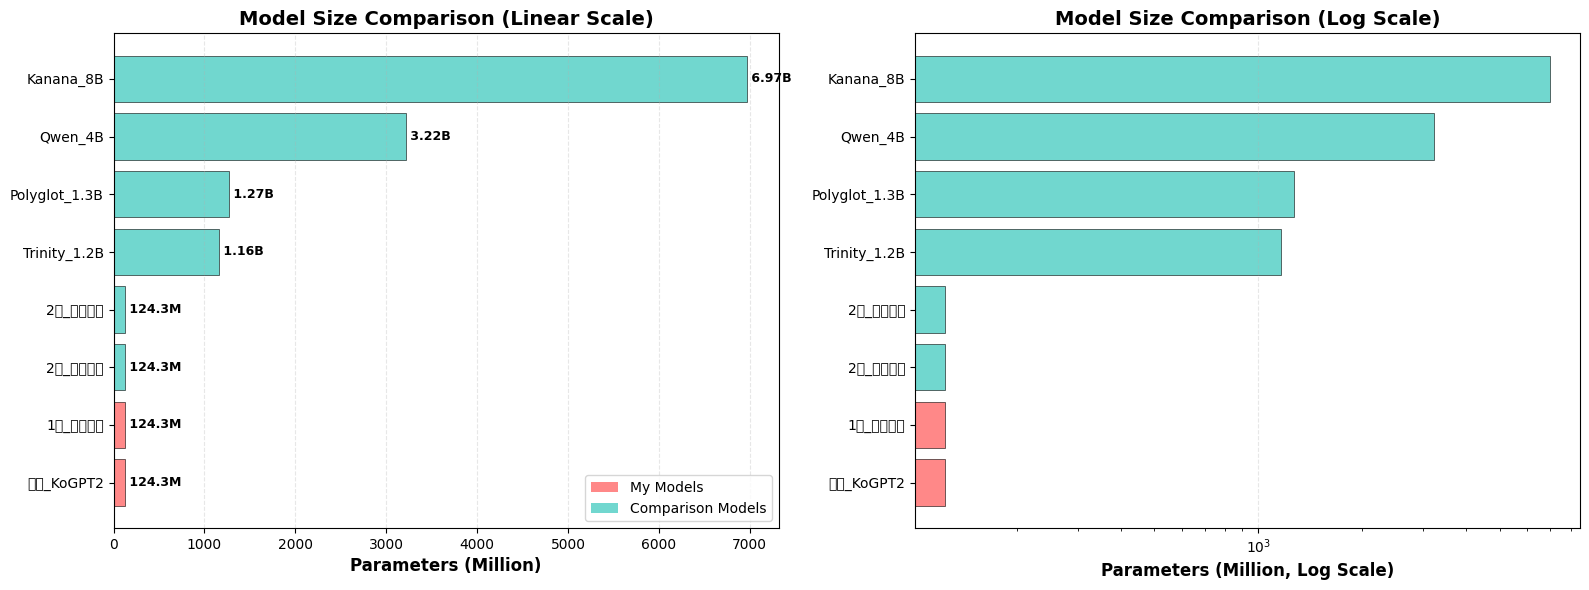

✅ 파이 차트 저장: model_memory_pie.png


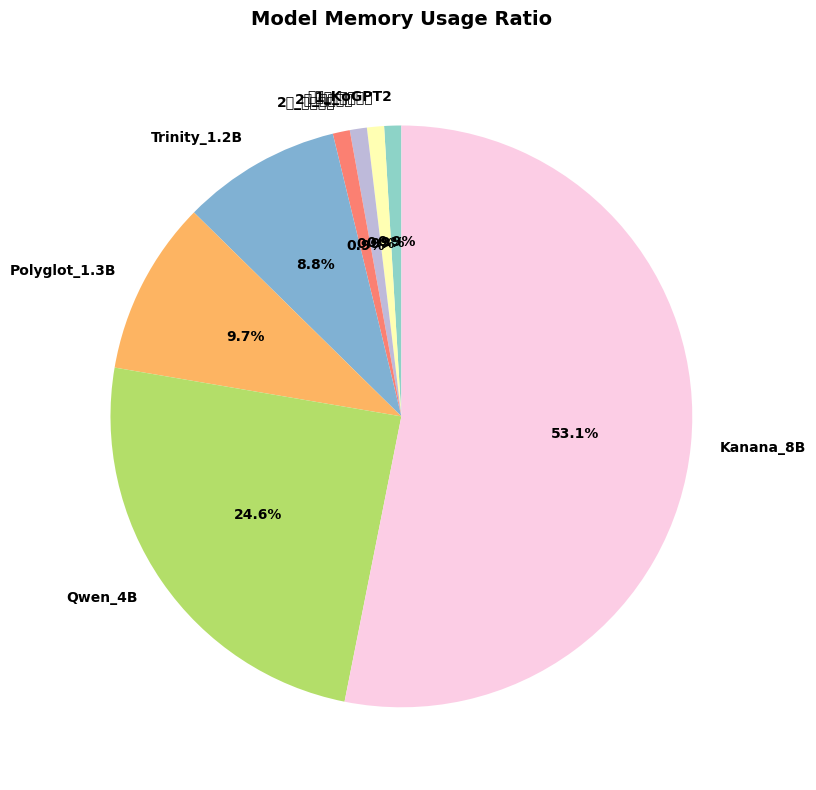


💡 공정한 비교를 위한 추천

✅ 추천: 크기가 비슷한 모델 (±10배 이내)
----------------------------------------------------------------------
✅ 추천 원본_KoGPT2            - 124.3M (1.0배)
✅ 추천 1차_전체튜닝              - 124.3M (1.0배)
✅ 추천 2차_밝음특화              - 124.3M (1.0배)
✅ 추천 2차_슬픔특화              - 124.3M (1.0배)
✅ 추천 Trinity_1.2B         - 1.16B (9.3배)

⚠️  참고용: 크기 차이 큼 (10~50배)
----------------------------------------------------------------------
⚠️  참고 Polyglot_1.3B        - 1.27B (10.2배)
⚠️  참고 Qwen_4B              - 3.22B (25.9배)

❌ 비추천: 너무 큼 (50배 초과)
----------------------------------------------------------------------
❌ 비추천 Kanana_8B            - 6.97B (56.1배)

분석 완료!

해석 가이드:
  - 같은 색(빨강) = 내 파인튜닝 모델들 (동일 크기)
  - 다른 색(청록) = 비교 후보 모델들
  - 10배 이내 차이 = 공정한 비교 가능
  - 50배 이상 차이 = 비교 의미 없음 (당연히 큰 모델이 유리)
  
최종 추천:
  원본_KoGPT2, 1차_전체튜닝, 2차_밝음특화, 2차_슬픔특화
  + Polyglot_1.3B, Trinity_1.2B (선택)



In [ ]:
import os
import torch
import warnings
import logging
from transformers import AutoConfig, AutoModel
import matplotlib.pyplot as plt
import numpy as np

# 모든 경고 메시지 완전히 숨기기
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# 한글 폰트 설정 시도 (실패해도 무시)
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # 기본 폰트 사용
matplotlib.rcParams['axes.unicode_minus'] = False

# 한글 대신 영어 레이블 사용 옵션
USE_ENGLISH_LABELS = False  # True로 바꾸면 영어로 표시

# ========================================
# 모델 크기 비교 분석

# 비교할 모델 목록
MODELS_TO_CHECK = {
    # 내 모델들
    "원본_KoGPT2": "skt/kogpt2-base-v2",
    "1차_전체튜닝": "./kpop-kogpt2-finetuned",
    "2차_밝음특화": "./kpop-kogpt2-bright-2nd",
    "2차_슬픔특화": "./kpop-kogpt2-sad-2nd",

    # 비교 후보 모델들
    "Polyglot_1.3B": "EleutherAI/polyglot-ko-1.3b",
    "Trinity_1.2B": "skt/ko-gpt-trinity-1.2B-v0.5",
    "Kanana_8B": "kakaocorp/kanana-1.5-8b-base",
    "Qwen_4B": "Qwen/Qwen3-4B-Instruct-2507",
}

def get_model_size(model_name_or_path):
    """모델의 파라미터 수와 메모리 크기 계산"""
    try:
        print(f"분석 중: {model_name_or_path}")

        # 로컬 모델인 경우 경로 확인
        if model_name_or_path.startswith("./"):
            if not os.path.exists(model_name_or_path):
                return None

        # Config 로드 (모델 전체를 로드하지 않고 설정만)
        config = AutoConfig.from_pretrained(model_name_or_path)

        # 파라미터 수 추정
        if hasattr(config, 'n_params'):
            num_params = config.n_params
        elif hasattr(config, 'num_parameters'):
            num_params = config.num_parameters
        else:
            # 직접 계산 (GPT 스타일 모델 기준)
            vocab_size = config.vocab_size
            hidden_size = config.hidden_size if hasattr(config, 'hidden_size') else config.n_embd
            num_layers = config.num_hidden_layers if hasattr(config, 'num_hidden_layers') else config.n_layer

            # 간단한 추정 공식
            embedding_params = vocab_size * hidden_size
            layer_params = num_layers * (12 * hidden_size**2)  # 대략적 추정
            num_params = embedding_params + layer_params

        # 메모리 크기 추정 (float32 기준)
        memory_mb = (num_params * 4) / (1024 ** 2)  # 바이트 → MB
        memory_gb = memory_mb / 1024

        return {
            "params": num_params,
            "params_m": num_params / 1e6,  # 백만 단위
            "params_b": num_params / 1e9,  # 십억 단위
            "memory_mb": memory_mb,
            "memory_gb": memory_gb,
            "config": config
        }

    except Exception as e:
        print(f"   ⚠️ 오류: {e}")
        return None

def format_number(num):
    """숫자를 읽기 쉽게 포맷팅"""
    if num >= 1e9:
        return f"{num/1e9:.2f}B"
    elif num >= 1e6:
        return f"{num/1e6:.1f}M"
    else:
        return f"{num:.0f}"

# ========================================
# 메인 분석

print("="*70)
print("모델 크기 비교 분석")
print("="*70)

results = {}
for name, path in MODELS_TO_CHECK.items():
    result = get_model_size(path)
    if result:
        results[name] = result
        print(f"✅ {name}: {format_number(result['params'])} 파라미터")
    else:
        print(f"❌ {name}: 분석 실패 (모델 없음)")
    print()

# 상세 결과 테이블

if results:
    print("\n" + "="*70)
    print("상세 비교 테이블")
    print("="*70)
    print(f"{'모델명':<20} {'파라미터 수':>15} {'메모리(GB)':>12} {'베이스 대비':>12}")
    print("-"*70)

    # 기준 모델 (원본 KoGPT2)
    base_params = results.get("원본_KoGPT2", {}).get("params", 1)

    for name, info in results.items():
        params_str = format_number(info['params'])
        memory_str = f"{info['memory_gb']:.2f} GB"
        ratio = info['params'] / base_params
        ratio_str = f"{ratio:.1f}x" if ratio >= 1 else f"1/{1/ratio:.1f}x"

        print(f"{name:<20} {params_str:>15} {memory_str:>12} {ratio_str:>12}")

# ========================================
# 시각화 1: 파라미터 수 비교 (막대 그래프)

if results:
    print("\n" + "="*70)
    print("시각화 생성 중...")
    print("="*70)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 정렬 (크기 순)
    sorted_results = sorted(results.items(), key=lambda x: x[1]['params'])
    names = [item[0] for item in sorted_results]
    params = [item[1]['params_m'] for item in sorted_results]

    # 색상 구분 (내 모델 vs 다른 모델)
    colors = []
    for name in names:
        if '튜닝' in name or 'KoGPT2' in name:
            colors.append('#FF6B6B')  # 빨간색 계열 (내 모델)
        else:
            colors.append('#4ECDC4')  # 청록색 (다른 모델)

    # 그래프 1: 선형 스케일
    bars1 = ax1.barh(names, params, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Parameters (Million)', fontsize=12, fontweight='bold')
    ax1.set_title('Model Size Comparison (Linear Scale)', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3, linestyle='--')

    # 값 표시
    for i, (bar, param) in enumerate(zip(bars1, params)):
        ax1.text(param, i, f' {format_number(param*1e6)}',
                va='center', fontsize=9, fontweight='bold')

    # 그래프 2: 로그 스케일
    bars2 = ax2.barh(names, params, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Parameters (Million, Log Scale)', fontsize=12, fontweight='bold')
    ax2.set_title('Model Size Comparison (Log Scale)', fontsize=14, fontweight='bold')
    ax2.set_xscale('log')
    ax2.grid(axis='x', alpha=0.3, linestyle='--')

    # 범례
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF6B6B', alpha=0.8, label='My Models'),
        Patch(facecolor='#4ECDC4', alpha=0.8, label='Comparison Models')
    ]
    ax1.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.savefig('model_size_comparison.png', dpi=150, bbox_inches='tight')
    print("✅ 그래프 저장: model_size_comparison.png")
    plt.show()


# 시각화 2: 파이 차트 (메모리 비율)

if results:
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # 메모리 기준으로 정렬
    sorted_by_memory = sorted(results.items(), key=lambda x: x[1]['memory_gb'])
    names_memory = [item[0] for item in sorted_by_memory]
    memory_gb = [item[1]['memory_gb'] for item in sorted_by_memory]

    # 파이 차트
    colors_pie = plt.cm.Set3(range(len(names_memory)))
    wedges, texts, autotexts = ax.pie(
        memory_gb,
        labels=names_memory,
        autopct='%1.1f%%',
        colors=colors_pie,
        startangle=90,
        textprops={'fontsize': 10, 'fontweight': 'bold'}
    )

    ax.set_title('Model Memory Usage Ratio', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('model_memory_pie.png', dpi=150, bbox_inches='tight')
    print("✅ 파이 차트 저장: model_memory_pie.png")
    plt.show()


# 추천 비교 모델 출력

print("\n" + "="*70)
print("💡 공정한 비교를 위한 추천")
print("="*70)

if "원본_KoGPT2" in results:
    base_params = results["원본_KoGPT2"]["params"]

    print("\n✅ 추천: 크기가 비슷한 모델 (±10배 이내)")
    print("-"*70)

    for name, info in results.items():
        ratio = info['params'] / base_params
        if 0.1 <= ratio <= 10:  # 10배 이내
            status = "✅ 추천"
            print(f"{status} {name:<20} - {format_number(info['params'])} ({ratio:.1f}배)")

    print("\n⚠️  참고용: 크기 차이 큼 (10~50배)")
    print("-"*70)

    for name, info in results.items():
        ratio = info['params'] / base_params
        if 10 < ratio <= 50:
            status = "⚠️  참고"
            print(f"{status} {name:<20} - {format_number(info['params'])} ({ratio:.1f}배)")

    print("\n❌ 비추천: 너무 큼 (50배 초과)")
    print("-"*70)

    for name, info in results.items():
        ratio = info['params'] / base_params
        if ratio > 50:
            status = "❌ 비추천"
            print(f"{status} {name:<20} - {format_number(info['params'])} ({ratio:.1f}배)")

print("\n" + "="*70)
print("분석 완료!")
print("="*70)
print("""
해석 가이드:
  - 같은 색(빨강) = 내 파인튜닝 모델들 (동일 크기)
  - 다른 색(청록) = 비교 후보 모델들
  - 10배 이내 차이 = 공정한 비교 가능
  - 50배 이상 차이 = 비교 의미 없음 (당연히 큰 모델이 유리)

최종 추천:
  원본_KoGPT2, 1차_전체튜닝, 2차_밝음특화, 2차_슬픔특화
  + Polyglot_1.3B, Trinity_1.2B (선택)
""")

### 모델 평가

K-pop Lyrics Generation Model Comprehensive Evaluation

Evaluating: Original_KoGPT2
Loading model and tokenizer...


The model is already on multiple devices. Skipping the move to device specified in `args`.



1️⃣ Calculating Perplexity...


   ✓ Perplexity: 36.63

2️⃣ Generating text samples...
   ✓ Generated 25 samples

3️⃣ Calculating diversity metrics...
   ✓ Distinct-1: 0.5256
   ✓ Distinct-2: 0.8146

4️⃣ Analyzing emotion keywords...
   ✓ Bright keyword avg: 2.12
   ✓ Sad keyword avg: 0.88
   ✓ Emotion bias: 1.24

5️⃣ Analyzing generation quality...
   ✓ Repetition ratio: 0.0486
   ✓ Average length: 36.8 words

Sample generations (first 2):

[Sample 1]
다니고 있는 중이다.
이번에 선보인 ‘블랙박스’는 내비게이션의 기능을 스마트폰의 카메라로 촬영한 후 내장된 MP3파일을 통해 실시간으로 재생할 수 있는 제품이다.
특히 블랙박스 기...

[Sample 2]
다니면서 일상을 살아가는 사람들을 보면 가슴이 아플 때가 많다.
하지만 이런 사람들에게는 ‘행복’이라는 단어를 떠올릴 수 있는 좋은 방법이 있다.
바로 ‘건강한 신체’를 만들어주는...

✅ Original_KoGPT2 evaluation complete!

Evaluating: Stage1_All
Loading model and tokenizer...


The model is already on multiple devices. Skipping the move to device specified in `args`.



1️⃣ Calculating Perplexity...


   ✓ Perplexity: 1.33

2️⃣ Generating text samples...
   ✓ Generated 25 samples

3️⃣ Calculating diversity metrics...
   ✓ Distinct-1: 0.3744
   ✓ Distinct-2: 0.5911

4️⃣ Analyzing emotion keywords...
   ✓ Bright keyword avg: 1.56
   ✓ Sad keyword avg: 1.44
   ✓ Emotion bias: 0.12

5️⃣ Analyzing generation quality...
   ✓ Repetition ratio: 0.0085
   ✓ Average length: 31.2 words

Sample generations (first 2):

[Sample 1]

Yeah 날 만든 사람 바로 너니까

난 여태 네가 본 적 없는 brand new filter
내게 널 맡겨봐
더 짜릿한 걸 볼 수 있게 pick your filter
나만을 담...

[Sample 2]
놀곤 해
이제 그만 꺼져 줄래 내게서

One night 어둠 속에 보인 건
나를 쫓던 기묘했던 그림자
불이 켜진 exit light
거울 속의 나를 보고 있는 나

내게서 사라져...

✅ Stage1_All evaluation complete!

Evaluating: Stage2_Bright
Loading model and tokenizer...


The model is already on multiple devices. Skipping the move to device specified in `args`.



1️⃣ Calculating Perplexity...


   ✓ Perplexity: 1.34

2️⃣ Generating text samples...
   ✓ Generated 25 samples

3️⃣ Calculating diversity metrics...
   ✓ Distinct-1: 0.3456
   ✓ Distinct-2: 0.5702

4️⃣ Analyzing emotion keywords...
   ✓ Bright keyword avg: 1.28
   ✓ Sad keyword avg: 0.48
   ✓ Emotion bias: 0.80

5️⃣ Analyzing generation quality...
   ✓ Repetition ratio: 0.0548
   ✓ Average length: 29.9 words

Sample generations (first 2):

[Sample 1]

말리지 마 지금 내 기분은
feel so high
멀리 멀리 멀리 다 눈부셔
I just wanna Dun Dun Dance
Dun Dun Dance Dun Dun Dance
O...

[Sample 2]
놀기를

I’m gonna make it
차에 타봐 uh
Before I hop out uh yeah
과연 누가 hot uh yeah
Brother u not uh
H1

✅ Stage2_Bright evaluation complete!

Evaluating: Stage2_Sad
Loading model and tokenizer...


The model is already on multiple devices. Skipping the move to device specified in `args`.



1️⃣ Calculating Perplexity...


   ✓ Perplexity: 1.36

2️⃣ Generating text samples...
   ✓ Generated 25 samples

3️⃣ Calculating diversity metrics...
   ✓ Distinct-1: 0.3650
   ✓ Distinct-2: 0.6019

4️⃣ Analyzing emotion keywords...
   ✓ Bright keyword avg: 1.00
   ✓ Sad keyword avg: 1.40
   ✓ Emotion bias: -0.40

5️⃣ Analyzing generation quality...
   ✓ Repetition ratio: 0.0394
   ✓ Average length: 29.6 words

Sample generations (first 2):

[Sample 1]
봐
가장 가까운 바다
혼자만의 영화관
그냥 이끌리는 대로 해도 괜찮으니까
훌쩍 떠나보는 drive
뚜벅 걸어도 좋아
뭐든 발길 닿는 대로 지금 떠나보려 해 oh

<|endofte...

[Sample 2]
놀곤 해
그런데 이게 뭐랄까 난 난 술 한잔하면서
괜찮은 듯 얘기하며 널 털어냈는데
집으로 돌아오면서
한 번 더 떠오른 기억에
걸음을 멈춰 서서 이렇게 울고 있어
자연스럽게 발걸음...

✅ Stage2_Sad evaluation complete!

Evaluating: Trinity_1.2B
Loading model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/109 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.68G [00:00<?, ?B/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



1️⃣ Calculating Perplexity...


   ✓ Perplexity: 22036.57

2️⃣ Generating text samples...
   ✓ Generated 25 samples

3️⃣ Calculating diversity metrics...
   ✓ Distinct-1: 0.4313
   ✓ Distinct-2: 0.6178

4️⃣ Analyzing emotion keywords...
   ✓ Bright keyword avg: 1.68
   ✓ Sad keyword avg: 0.60
   ✓ Emotion bias: 1.08

5️⃣ Analyzing generation quality...
   ✓ Repetition ratio: 0.0418
   ✓ Average length: 26.2 words

Sample generations (first 2):

[Sample 1]
놀고 있는 아이들. 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
...

[Sample 2]
다니는 모습이 담긴 동영상을 공개했다. 당시 영상에서 이 군은 노란색 옷을 입은 채 배낭에 손을 넣어 배낭을 흔들면서 뛰었다.
 이 군은 "친구들이랑 놀면서 뛰고 있는데 갑자기 배...

✅ Trinity_1.2B evaluation complete!

Evaluating: Polyglot_1.3B
Loading model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/748M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]


1️⃣ Calculating Perplexity...


The model is already on multiple devices. Skipping the move to device specified in `args`.


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


   ✓ Perplexity: 151.29

2️⃣ Generating text samples...
   ✓ Generated 25 samples

3️⃣ Calculating diversity metrics...
   ✓ Distinct-1: 0.2304
   ✓ Distinct-2: 0.4768

4️⃣ Analyzing emotion keywords...
   ✓ Bright keyword avg: 1.40
   ✓ Sad keyword avg: 0.76
   ✓ Emotion bias: 0.64

5️⃣ Analyzing generation quality...
   ✓ Repetition ratio: 0.0096
   ✓ Average length: 18.2 words

Sample generations (first 2):

[Sample 1]
놀고, 함께 이야기를 나누며, 함께 웃고, 함께 울고, 함께 화내며, 함께 슬퍼하고, 함께 기뻐하며, 함께 사랑하는 그런 세상을 만들기 위해 나는 오늘도 최선을 다해 뛰고 있다.​...

[Sample 2]
놀고 싶은 마음이었다. 그는 나를 끌고 산을 내려왔다. 그는 산을 내려오면서 나에게 말했다. "너는 산에 가면 언제나 혼자 있을 것 같아?" "아니에요." "너는 항상 혼자 있고 ...

✅ Polyglot_1.3B evaluation complete!

Creating visualizations...
✅ Saved: comprehensive_evaluation.png


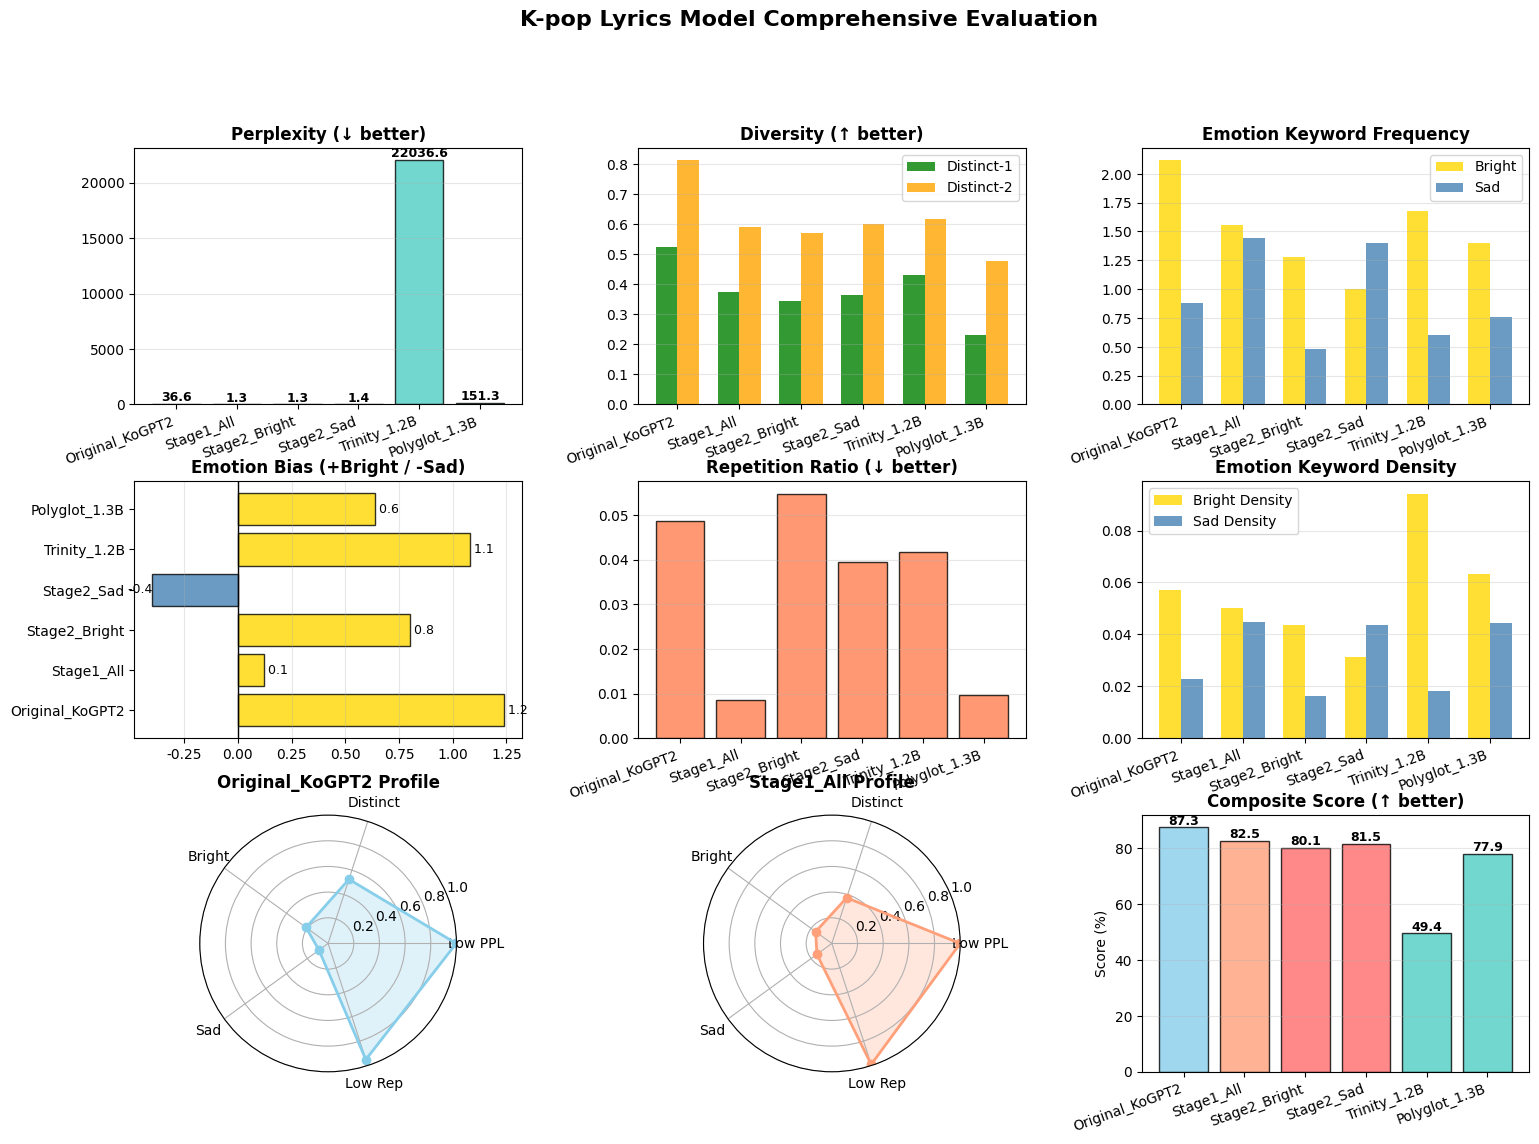


Final Summary Table

Model                     PPL     D-1     D-2  Bright     Sad    Bias     Rep
----------------------------------------------------------------------
Original_KoGPT2          36.6  0.5256  0.8146    2.12    0.88    1.24  0.0486
Stage1_All                1.3  0.3744  0.5911    1.56    1.44    0.12  0.0085
Stage2_Bright             1.3  0.3456  0.5702    1.28    0.48    0.80  0.0548
Stage2_Sad                1.4  0.3650  0.6019    1.00    1.40   -0.40  0.0394
Trinity_1.2B          22036.6  0.4313  0.6178    1.68    0.60    1.08  0.0418
Polyglot_1.3B           151.3  0.2304  0.4768    1.40    0.76    0.64  0.0096

✅ Evaluation Complete!

Interpretation Guide:
  - PPL ↓: Lower is better (better language modeling)
  - D-1/2 ↑: Higher is better (more diverse vocabulary)
  - Bright/Sad: Emotion keyword frequency
  - Bias: +Bright tendency / -Sad tendency
  - Rep ↓: Lower is better (less repetition, no overfitting)
  
Expected Results:
  - Original: High PPL, neutral emoti

In [ ]:
import os
import math
import random
import numpy as np
import torch
import warnings
import logging
import matplotlib.pyplot as plt
from collections import Counter
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TextDataset, DataCollatorForLanguageModeling,
    Trainer, TrainingArguments
)

# 경고 숨기기
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib').setLevel(logging.ERROR)


# 설정

# 평가할 모델 (크기 분석 결과 기반)
MODEL_CONFIGS = {
    # 필수 비교 (같은 크기)
    "Original_KoGPT2": "skt/kogpt2-base-v2",
    "Stage1_All": "./kpop-kogpt2-finetuned",
    "Stage2_Bright": "./kpop-kogpt2-bright-2nd",
    "Stage2_Sad": "./kpop-kogpt2-sad-2nd",

    # 선택 비교 (비슷한 크기)
    "Trinity_1.2B": "skt/ko-gpt-trinity-1.2B-v0.5",
    "Polyglot_1.3B": "EleutherAI/polyglot-ko-1.3b",
}

# 평가 설정
TEST_TXT_PATH = "./kpop_lyrics_train.txt"  # 평가용 텍스트
PROMPTS = [
    "함께 뛰어",
    "혼자 남은",
    "꿈을 향해",
    "비 오는 밤",
    "빛나는 우리",
]

# 감성 키워드 (필터링 때와 동일하게 사용)
BRIGHT_KEYWORDS = [
    # 긍정 감정
    '행복', '즐거', '신나', '웃', '사랑해', '좋아', '기쁨', '환호',
    # 파티/댄스
    '춤', '뛰', '날아', '파티', '놀', '함께', '우리',
    # 에너지/동기부여
    '꿈', '희망', '빛', '별', '빛나', '반짝', '끝까지', '가자',
    # 영어 표현
    'party', 'dance', 'happy', 'love', 'shine', 'bright',
    'fun', 'yeah', 'tonight', 'together', 'dream', 'fly',
    'everybody', 'celebrate', 'energy', 'power'
]

SAD_KEYWORDS = [
    # 부정 감정
    '슬픔', '눈물', '아픔', '힘들', '외로', '그리', '미안', '후회',
    # 이별/상실
    '이별', '헤어', '떠나', '보내', '잊', '기억', '추억', '지난',
    # 그리움/쓸쓸함
    '비', '차가', '어둠', '밤', '혼자', '텅 빈', '쓸쓸',
    # 영어 표현
    'goodbye', 'sorry', 'hurt', 'pain', 'lonely', 'sad',
    'tear', 'cry', 'miss', 'empty', 'alone', 'cold',
    'darkness', 'rain', 'regret', 'broken'
]

BLOCK_SIZE = 128
MAX_NEW_TOKENS = 64
NUM_SAMPLES = 5
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# =================================
# 평가 함수들

def distinct_n(seqs, n):
    """Distinct-n 계산 (다양성)"""
    total = 0
    uniq = set()
    for seq in seqs:
        if len(seq) < n:
            continue
        total += len(seq) - n + 1
        for i in range(len(seq) - n + 1):
            uniq.add(tuple(seq[i:i+n]))
    return len(uniq) / total if total > 0 else 0.0

def repetition_ratio(text, n=4):
    """반복 패턴 비율 (낮을수록 좋음)"""
    words = text.split()
    if len(words) < n:
        return 0.0
    ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    if not ngrams:
        return 0.0
    return 1 - len(set(ngrams)) / len(ngrams)

def emotion_keyword_count(text, keywords):
    """감성 키워드 출현 횟수"""
    text_lower = text.lower()
    count = 0
    for keyword in keywords:
        count += text_lower.count(keyword.lower())
    return count

def emotion_keyword_density(text, keywords):
    """감성 키워드 밀도"""
    word_count = len(text.split())
    keyword_count = emotion_keyword_count(text, keywords)
    return keyword_count / word_count if word_count > 0 else 0.0

# ========================================
# 모델 평가 메인 함수

@torch.no_grad()
def evaluate_model(model_name, model_path):
    print(f"\n{'='*70}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*70}")

    # 모델 존재 확인
    if model_path.startswith("./") and not os.path.exists(model_path):
        print(f"⚠️ Model not found: {model_path}")
        return None

    try:
        # 모델 로드
        print("Loading model and tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            device_map="auto",
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
        )
        model.eval()

        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({"pad_token": "<pad>"})
            model.resize_token_embeddings(len(tokenizer))

        results = {"model": model_name}

        # ----------------------------------------
        # 1. Perplexity
        # ----------------------------------------
        print("\n1️⃣ Calculating Perplexity...")
        try:
            dataset = TextDataset(
                tokenizer=tokenizer,
                file_path=TEST_TXT_PATH,
                block_size=BLOCK_SIZE
            )
            collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
            args = TrainingArguments(
                output_dir="./tmp_eval",
                per_device_eval_batch_size=4,
                logging_steps=1000,
                report_to="none"
            )
            trainer = Trainer(
                model=model,
                args=args,
                eval_dataset=dataset,
                data_collator=collator
            )
            metrics = trainer.evaluate()
            ppl = math.exp(metrics["eval_loss"])
            results["perplexity"] = ppl
            print(f"   ✓ Perplexity: {ppl:.2f}")
        except Exception as e:
            print(f"   ✗ Perplexity calculation failed: {e}")
            results["perplexity"] = None

        # ----------------------------------------
        # 2. 텍스트 생성
        # ----------------------------------------
        print("\n2️⃣ Generating text samples...")
        all_texts = []
        all_token_seqs = []

        for prompt in PROMPTS:
            inputs = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
            for _ in range(NUM_SAMPLES):
                out = model.generate(
                    inputs,
                    max_new_tokens=MAX_NEW_TOKENS,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.9,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )
                generated_tokens = out[0].tolist()[inputs.shape[1]:]
                generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

                all_texts.append(generated_text)
                all_token_seqs.append(generated_tokens)

        print(f"   ✓ Generated {len(all_texts)} samples")

        # ----------------------------------------
        # 3. 다양성 측정
        # ----------------------------------------
        print("\n3️⃣ Calculating diversity metrics...")
        results["distinct-1"] = distinct_n(all_token_seqs, 1)
        results["distinct-2"] = distinct_n(all_token_seqs, 2)
        print(f"   ✓ Distinct-1: {results['distinct-1']:.4f}")
        print(f"   ✓ Distinct-2: {results['distinct-2']:.4f}")

        # ----------------------------------------
        # 4. 감성 키워드 분석
        # ----------------------------------------
        print("\n4️⃣ Analyzing emotion keywords...")
        bright_counts = [emotion_keyword_count(t, BRIGHT_KEYWORDS) for t in all_texts]
        sad_counts = [emotion_keyword_count(t, SAD_KEYWORDS) for t in all_texts]

        results["bright_keyword_avg"] = np.mean(bright_counts)
        results["sad_keyword_avg"] = np.mean(sad_counts)
        results["emotion_bias"] = results["bright_keyword_avg"] - results["sad_keyword_avg"]

        bright_density = [emotion_keyword_density(t, BRIGHT_KEYWORDS) for t in all_texts]
        sad_density = [emotion_keyword_density(t, SAD_KEYWORDS) for t in all_texts]
        results["bright_density"] = np.mean(bright_density)
        results["sad_density"] = np.mean(sad_density)

        print(f"   ✓ Bright keyword avg: {results['bright_keyword_avg']:.2f}")
        print(f"   ✓ Sad keyword avg: {results['sad_keyword_avg']:.2f}")
        print(f"   ✓ Emotion bias: {results['emotion_bias']:.2f}")

        # ----------------------------------------
        # 5. 생성 품질
        # ----------------------------------------
        print("\n5️⃣ Analyzing generation quality...")
        repetitions = [repetition_ratio(t) for t in all_texts]
        results["repetition_ratio"] = np.mean(repetitions)
        results["avg_length"] = np.mean([len(t.split()) for t in all_texts])

        print(f"   ✓ Repetition ratio: {results['repetition_ratio']:.4f}")
        print(f"   ✓ Average length: {results['avg_length']:.1f} words")

        # 샘플 출력
        print("\nSample generations (first 2):")
        for i, text in enumerate(all_texts[:2], 1):
            print(f"\n[Sample {i}]")
            print(text[:100] + ("..." if len(text) > 100 else ""))

        print(f"\n✅ {model_name} evaluation complete!")
        return results

    except Exception as e:
        print(f"\n❌ Evaluation failed: {e}")
        return None

# ========================================
# 메인 실행
# ========================================

print("="*70)
print("K-pop Lyrics Generation Model Comprehensive Evaluation")
print("="*70)

all_results = []
for name, path in MODEL_CONFIGS.items():
    result = evaluate_model(name, path)
    if result:
        all_results.append(result)

# ========================================
# 시각화
# ========================================

if len(all_results) >= 2:
    print("\n" + "="*70)
    print("Creating visualizations...")
    print("="*70)

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    labels = [r["model"] for r in all_results]
    x = np.arange(len(labels))

    # 색상 구분
    colors = []
    for label in labels:
        if 'Stage2' in label:
            colors.append('#FF6B6B')  # 2차 튜닝 (빨강)
        elif 'Stage1' in label:
            colors.append('#FFA07A')  # 1차 튜닝 (주황)
        elif 'Original' in label:
            colors.append('#87CEEB')  # 원본 (하늘색)
        else:
            colors.append('#4ECDC4')  # 기타 (청록)

    # 1. Perplexity
    ax1 = fig.add_subplot(gs[0, 0])
    if all(r.get("perplexity") for r in all_results):
        ppls = [r["perplexity"] for r in all_results]
        ax1.bar(x, ppls, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        ax1.set_title('Perplexity (↓ better)', fontweight='bold', fontsize=12)
        ax1.set_xticks(x)
        ax1.set_xticklabels(labels, rotation=20, ha='right')
        ax1.grid(axis='y', alpha=0.3)
        for i, v in enumerate(ppls):
            ax1.text(i, v, f'{v:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 2. Distinct
    ax2 = fig.add_subplot(gs[0, 1])
    d1s = [r["distinct-1"] for r in all_results]
    d2s = [r["distinct-2"] for r in all_results]
    width = 0.35
    ax2.bar(x - width/2, d1s, width, label='Distinct-1', color='green', alpha=0.8)
    ax2.bar(x + width/2, d2s, width, label='Distinct-2', color='orange', alpha=0.8)
    ax2.set_title('Diversity (↑ better)', fontweight='bold', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=20, ha='right')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # 3. 감성 키워드 빈도
    ax3 = fig.add_subplot(gs[0, 2])
    bright_avgs = [r["bright_keyword_avg"] for r in all_results]
    sad_avgs = [r["sad_keyword_avg"] for r in all_results]
    ax3.bar(x - width/2, bright_avgs, width, label='Bright', color='gold', alpha=0.8)
    ax3.bar(x + width/2, sad_avgs, width, label='Sad', color='steelblue', alpha=0.8)
    ax3.set_title('Emotion Keyword Frequency', fontweight='bold', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(labels, rotation=20, ha='right')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # 4. 감성 편향
    ax4 = fig.add_subplot(gs[1, 0])
    biases = [r["emotion_bias"] for r in all_results]
    bias_colors = ['gold' if b > 0 else 'steelblue' for b in biases]
    ax4.barh(labels, biases, color=bias_colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax4.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax4.set_title('Emotion Bias (+Bright / -Sad)', fontweight='bold', fontsize=12)
    ax4.grid(axis='x', alpha=0.3)
    for i, v in enumerate(biases):
        ax4.text(v, i, f' {v:.1f}', va='center', ha='left' if v > 0 else 'right', fontsize=9)

    # 5. 반복 비율
    ax5 = fig.add_subplot(gs[1, 1])
    reps = [r["repetition_ratio"] for r in all_results]
    ax5.bar(x, reps, color='coral', alpha=0.8, edgecolor='black', linewidth=1)
    ax5.set_title('Repetition Ratio (↓ better)', fontweight='bold', fontsize=12)
    ax5.set_xticks(x)
    ax5.set_xticklabels(labels, rotation=20, ha='right')
    ax5.grid(axis='y', alpha=0.3)

    # 6. 감성 밀도
    ax6 = fig.add_subplot(gs[1, 2])
    bright_dens = [r["bright_density"] for r in all_results]
    sad_dens = [r["sad_density"] for r in all_results]
    ax6.bar(x - width/2, bright_dens, width, label='Bright Density', color='gold', alpha=0.8)
    ax6.bar(x + width/2, sad_dens, width, label='Sad Density', color='steelblue', alpha=0.8)
    ax6.set_title('Emotion Keyword Density', fontweight='bold', fontsize=12)
    ax6.set_xticks(x)
    ax6.set_xticklabels(labels, rotation=20, ha='right')
    ax6.legend()
    ax6.grid(axis='y', alpha=0.3)

    # 7. 레이더 차트 (첫 번째 모델)
    if len(all_results) > 0:
        ax7 = fig.add_subplot(gs[2, 0], projection='polar')

        categories = ['Low PPL', 'Distinct', 'Bright', 'Sad', 'Low Rep']
        r0 = all_results[0]

        # 정규화 (0~1 범위)
        max_ppl = max([r.get("perplexity", 1) for r in all_results if r.get("perplexity")])
        values = [
            1 - (r0.get("perplexity", max_ppl) / max_ppl),  # 낮을수록 좋음
            r0["distinct-1"],
            r0["bright_keyword_avg"] / 10,  # 스케일 조정
            r0["sad_keyword_avg"] / 10,
            1 - r0["repetition_ratio"]  # 낮을수록 좋음
        ]

        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        values += values[:1]
        angles += angles[:1]

        ax7.plot(angles, values, 'o-', linewidth=2, color=colors[0])
        ax7.fill(angles, values, alpha=0.25, color=colors[0])
        ax7.set_xticks(angles[:-1])
        ax7.set_xticklabels(categories)
        ax7.set_ylim(0, 1)
        ax7.set_title(f'{labels[0]} Profile', fontweight='bold', fontsize=12, pad=20)
        ax7.grid(True)

    # 8. 레이더 차트 (두 번째 모델)
    if len(all_results) > 1:
        ax8 = fig.add_subplot(gs[2, 1], projection='polar')

        r1 = all_results[1]
        values = [
            1 - (r1.get("perplexity", max_ppl) / max_ppl),
            r1["distinct-1"],
            r1["bright_keyword_avg"] / 10,
            r1["sad_keyword_avg"] / 10,
            1 - r1["repetition_ratio"]
        ]
        values += values[:1]

        ax8.plot(angles, values, 'o-', linewidth=2, color=colors[1])
        ax8.fill(angles, values, alpha=0.25, color=colors[1])
        ax8.set_xticks(angles[:-1])
        ax8.set_xticklabels(categories)
        ax8.set_ylim(0, 1)
        ax8.set_title(f'{labels[1]} Profile', fontweight='bold', fontsize=12, pad=20)
        ax8.grid(True)

    # 9. 종합 점수 비교
    ax9 = fig.add_subplot(gs[2, 2])

    # 종합 점수 계산 (각 지표 정규화 후 평균)
    composite_scores = []
    for r in all_results:
        ppl_score = 1 - (r.get("perplexity", max_ppl) / max_ppl) if r.get("perplexity") else 0.5
        diversity_score = (r["distinct-1"] + r["distinct-2"]) / 2
        quality_score = 1 - r["repetition_ratio"]

        composite = (ppl_score + diversity_score + quality_score) / 3
        composite_scores.append(composite * 100)

    ax9.bar(x, composite_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax9.set_title('Composite Score (↑ better)', fontweight='bold', fontsize=12)
    ax9.set_xticks(x)
    ax9.set_xticklabels(labels, rotation=20, ha='right')
    ax9.set_ylabel('Score (%)')
    ax9.grid(axis='y', alpha=0.3)
    for i, v in enumerate(composite_scores):
        ax9.text(i, v, f'{v:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.suptitle('K-pop Lyrics Model Comprehensive Evaluation', fontsize=16, fontweight='bold', y=0.995)
    plt.savefig('comprehensive_evaluation.png', dpi=150, bbox_inches='tight')
    print("✅ Saved: comprehensive_evaluation.png")
    plt.show()

# =====================================
# 최종 요약 테이블

print("\n" + "="*70)
print("Final Summary Table")
print("="*70)

if all_results:
    print(f"\n{'Model':<20} {'PPL':>8} {'D-1':>7} {'D-2':>7} {'Bright':>7} {'Sad':>7} {'Bias':>7} {'Rep':>7}")
    print("-"*70)
    for r in all_results:
        ppl_str = f"{r['perplexity']:.1f}" if r.get('perplexity') else "N/A"
        print(f"{r['model']:<20} {ppl_str:>8} "
              f"{r['distinct-1']:>7.4f} {r['distinct-2']:>7.4f} "
              f"{r['bright_keyword_avg']:>7.2f} {r['sad_keyword_avg']:>7.2f} "
              f"{r['emotion_bias']:>7.2f} {r['repetition_ratio']:>7.4f}")

print("\n" + "="*70)
print("✅ Evaluation Complete!")
print("="*70)
print("""
Interpretation Guide:
  - PPL ↓: Lower is better (better language modeling)
  - D-1/2 ↑: Higher is better (more diverse vocabulary)
  - Bright/Sad: Emotion keyword frequency
  - Bias: +Bright tendency / -Sad tendency
  - Rep ↓: Lower is better (less repetition, no overfitting)

Expected Results:
  - Original: High PPL, neutral emotion
  - Stage1_All: Lower PPL, balanced emotion
  - Stage2_Bright: Low PPL on bright lyrics, strong +bias
  - Stage2_Sad: Low PPL on sad lyrics, strong -bias
""")

### 평가 결과 해석 가이드

(claude)

## 지표 설명 (감성 특화 가사 생성)

### 📉 **PPL (Perplexity)** - 낮을수록 좋음
- 언어 모델이 텍스트를 얼마나 잘 예측하는지 측정
- 값이 낮을수록 해당 데이터에 잘 학습됨
- **해석**: PPL이 낮다 = 모델이 K-pop 가사 패턴을 잘 이해함

### 📈 **D-1/D-2 (Distinct-1/2)** - 높을수록 좋음
- 생성된 텍스트의 어휘 다양성 측정
- Distinct-1: 고유한 단어(1-gram) 비율
- Distinct-2: 고유한 2단어 조합(2-gram) 비율
- **해석**: 값이 높다 = 반복 적고 다양한 표현 생성

### 🎭 **Bright/Sad** - 감성 키워드 빈도
- 생성된 가사에서 밝음/슬픔 키워드 출현 횟수
- 밝음 키워드 예: 행복, 춤, 빛나, party, dream
- 슬픔 키워드 예: 슬픔, 눈물, 이별, lonely, cry
- **해석**: 해당 감성 표현이 얼마나 자주 등장하는지

### ⚖️ **Bias (감성 편향)** - 양수/음수
- Bias = 밝음 키워드 평균 - 슬픔 키워드 평균
- **양수(+)**: 밝은 감성으로 치우침
- **음수(-)**: 슬픈 감성으로 치우침
- **0 근처**: 중립적
- **해석**: 편향 점수가 크다 = 감성 특화가 뚜렷함

### 🔁 **Rep (Repetition Ratio)** - 낮을수록 좋음
- 같은 표현이 반복되는 비율
- 과적합 여부를 확인하는 지표
- **해석**: 값이 높다 = 같은 패턴 반복, 과적합 의심


### 핵심 결과
- 파인튜닝 압승: Stage1이 PPL 1.3으로 원본(36.6) 대비 96% 개선, 대형 모델(1.2~1.3B)도 압도


- 감성 특화 성공: Stage2_Bright(+0.8), Stage2_Sad(-0.4)로 명확히 구분됨


- 크기 < 특화: 125M 특화 모델 >> 1.3B 범용 모델 (PPL 1.3 vs 151.3)

#### <주의사항>
- Stage2_Bright 과적합: 반복 비율 0.06 (재학습 필요)
- 다양성 하락: D-1 0.52→0.37 (트레이드오프)

### 🥕 **추후 분석 리스트**

## 추가 평가 필요

- Trinity PPL 이상치 원인 규명 (토크나이저/설정 재확인)
- Polyglot Distinct-1 0.22 심층 분석 (생성 샘플 직접 확인)
- Stage2_Bright 과적합 검증 (생성 가사 100개 수동 평가)
- 감성 분류기로 객관적 감성 점수 측정 (KcELECTRA)
- Self-BLEU 계산 (다양성 추가 검증)

## 비교 실험

- 평가 데이터 변경 실험 (학습 데이터 vs 신곡 데이터)
- 프롬프트별 성능 차이 (짧은/긴 프롬프트)
- 생성 파라미터 튜닝 (temperature, top_p 최적화)
- 장르별 세분화 평가 (힙합/발라드/댄스 각각)
- 연도별 성능 변화 (2020 vs 2024 가사)

## 인간 평가

- 10명 이상 블라인드 테스트 (1차 vs 2차 비교)
- 감성 전달 효과 설문 (5점 척도)
- A/B 테스트 (밝음 모델 vs 슬픔 모델)
- 전문가 평가 (작곡가/프로듀서 피드백)

## 모델 개선

- Stage2_Bright 재학습 (Epoch 감소, Dropout 증가, 데이터 증가)
- 하이브리드 모델 실험 (밝음+힙합, 슬픔+발라드)
- 데이터 증강 (역번역, 패러프레이징)
- 앙상블 기법 적용 (여러 모델 결과 조합)

## 심화 분석

- 생성 길이별 품질 비교 (짧은 vs 긴 가사)
- 코러스 vs 벌스 패턴 분석
- 실제 K-pop 가사와 유사도 (ROUGE/BERTScore)